# Лабораторная работа №1

In [1]:
import graphblas as gb

gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread
from scipy.sparse import coo_matrix
import numpy as np

In [2]:
# Будем использовать ту же матрицу M:
M = mmread('karate.mtx')
M

"M_0"      nvals  nrows  ncols  dtype     format
gb.Matrix    156     34     34   FP64  csr (iso)
------------------------------------------------
     0    1    2    3    4    5    6    7    8    9   ...   24   25   26   27  \
0        1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0       ...                       
1   1.0       1.0  1.0                 1.0            ...                       
2   1.0  1.0       1.0                 1.0  1.0  1.0  ...                 1.0   
3   1.0  1.0  1.0                      1.0            ...                       
4   1.0                           1.0                 ...                       
5   1.0                           1.0                 ...                       
6   1.0                 1.0  1.0                      ...                       
7   1.0  1.0  1.0  1.0                                ...                       
8   1.0       1.0                                     ...                       
9             1.0                                     ...                       
10  1.0                 1.0  1.0                      ...                       
11  1.0                                               ...                       
12  1.0            1.0                                ...                       
13  1.0  1.0  1.0  1.0                                ...                       
14                                                    ...                       
15                                                    ...                       
16                           1.0  1.0                 ...                       
17  1.0  1.0                                          ...                       
18                                                    ...                       
19  1.0  1.0                                          ...                       
20                                                    ...                       
21  1.0  1.0                                          ...                       
22                                                    ...                       
23                                                    ...       1.0       1.0   
24                                                    ...       1.0       1.0   
25                                                    ...  1.0                  
26                                                    ...                       
27            1.0                                     ...  1.0                  
28            1.0                                     ...                       
29                                                    ...            1.0        
30       1.0                                1.0       ...                       
31  1.0                                               ...  1.0  1.0             
32            1.0                           1.0       ...                       
33                                          1.0  1.0  ...            1.0  1.0   

     28   29   30   31   32   33  
0                  1.0            
1             1.0                 
2   1.0                 1.0       
3                                 
4                                 
5                                 
6                                 
7                                 
8             1.0       1.0  1.0  
9                            1.0  
10                                
11                                
12                                
13                           1.0  
14                      1.0  1.0  
15                      1.0  1.0  
16                                
17                                
18                      1.0  1.0  
19                           1.0  
20                      1.0  1.0  
21                                
22                      1.0  1.0  
23       1.0            1.0  1.0  
24                 1.0            
25                 1.0            
26       1.0                 1.0  
27                           1.0  
28

In [3]:
M.dtype

FP64

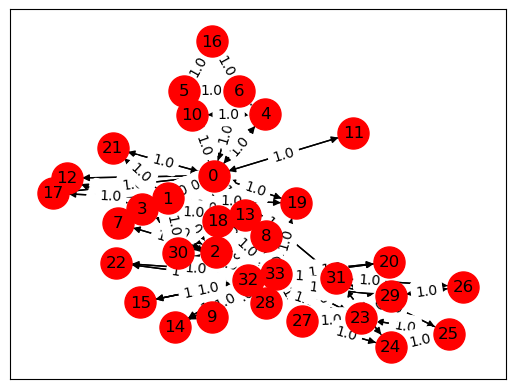

In [4]:
gb.viz.draw(M)

### 1)
Используя python-graphblas реализовать **наивный алгоритм**, для матрицы смежности вычисляющий и возвращающий количество треугольников неориентированного графа. <br>
Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).<br>
Функция возвращает число --- количество треугольников в графе.

In [5]:
def naiveA3(A):
    # Умножаем м-цу A на A:
    A2 = A.mxm(A)
    
    # Находим м-цу A^3
    A3 = A2.mxm(A)
    
    # Выделяем все пути длины три где начало пути и конец пути совпадают (диагональ матрицы)
    A3diag = A3.diag()
    
    # Находим След матрицы A^3 то есть суммируем все элементы матрицы A^3 диагонали
    # .value возвращает значение суммы reduce
    # or 0 для случая если треугольников нет
    Trace = int(A3diag.reduce(gb.agg.sum).value or 0)
    
    # Найдем кол-во треугольников
    # Делим на 6 тк дважды считали по направлению треугольника (почасовой и противчасовой) * (начинаем с трех вершин) = 6
    NumTri = Trace / 6
    
    return NumTri

### 2)
Используя python-graphblas реализовать **наивный алгоритм с маской**, для матрицы смежности вычисляющий и возвращающий количество треугольников неориентированного графа. <br>
Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно). <br>
Функция возвращает число --- количество треугольников в графе.

In [6]:
def naiveMaskA2(A):
    # Найдем матрицу A^2:
    A2 = A.mxm(A)
    
    # Найдем маску на основе матрицы смежности A (Оставляем ячейки со значениями True где были ребра в графе)
    maska = A.dup(dtype=dtypes.BOOL)

    # Применим маску к матрице A^2, Оставим все пути длины 2 (матрица A^2) между вершинами, где еще есть путь длины 1 (маска)
    A2maska = A2.dup(mask=maska)
    
    # Просуммируем все элементы матрицы в одно число или вернем 0 
    NumTri_with_six_pairs = int(A2maska.reduce_scalar(gb.monoid.plus).value or 0)
    
    # Так же поделим на 6 тк мы посчитали один треугольник 6 раз:
    # дважды считали по направлению треугольника (почасовой и противчасовой) * (начинаем с трех вершин) = 6
    NumTri = NumTri_with_six_pairs / 6
    
    return NumTri

### 3)
Используя python-graphblas реализовать **Сohen's algorithm**, вычисляющий количество треугольников неориентированного графа. <br>
Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).<br>
Функция возвращает число --- количество треугольников в графе.

In [7]:
def cohen(A):
    # Найдем нижнетреугольную матрицу от матрицы A:
    # найдем все пути типа hi->lo
    L = gb.select.tril(A)
    
    # Найдем верхнетреугольную матрицу от матрицы A:
    # найдем все пути типа lo->hi
    U = gb.select.triu(A)
    
    # Создадим маску на основе матрицы смежности A:
    # Для того чтобы закрыть клин типа hi->lo->hi нужен путь из hi в hi (hi->hi) (применим маску)
    maska = A.dup(dtype=dtypes.BOOL)
    
    # Умножим L на U (найдем все клинья типа hi->lo->hi) и 
    # применяя маску "maska" (закроем клин ребром hi->hi)
    LUmaska = L.mxm(U).dup(mask=maska)
    
    # Просуммируем все в число если есть чтото или вернем 0
    NumTri_with_pair = int(LUmaska.reduce_scalar(gb.monoid.plus).value or 0)
    
    # Поделим это число на 2 тк мы идентифицируем треугольники по min (lo) вершине 
    # а проход мы посчитали как hi1->lo->hi2 и hi1<-lo<-hi2 (то есть дважды)
    NumTri = NumTri_with_pair / 2
    
    return NumTri

### 4)
Используя python-graphblas реализовать **Sandia algorithm**, вычисляющий количество треугольников неориентированного графа.<br>
Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).<br>
Функция возвращает число --- количество треугольников в графе.

In [8]:
def sandia(A):
    # Найдем нижнетреугольную матрицу от матрицы A:
    # найдем все пути типа hi->lo
    L = gb.select.tril(A)

    # Создадим маску на основе матрицы L:
    maska = L.dup(dtype=dtypes.BOOL)
    
    # Для того чтобы найти пути от max, middle, min вершины и
    # применяя маску "maska" (закроем ребром max->min)
    LLmaska = L.mxm(L).dup(mask=maska)
    
    # Просуммируем все в число если есть чтото или вернем 0
    NumTri = float(LLmaska.reduce_scalar(gb.monoid.plus).value or 0)
    
    return NumTri

In [9]:
def test(A):
    result = [naiveA3(A), naiveMaskA2(A), cohen(A), sandia(A)]
    print(result)
    if not all(result[0] == element for element in result):
       print("All return values are not equal")
    else:
        print('NaiveA3:')
        %timeit naiveA3(A)
        
        print('NaiveA2:')
        %timeit naiveMaskA2(A)
        
        print('Cohens:')
        %timeit cohen(A)
        
        print('Sandia:')
        %timeit sandia(A)

In [10]:
test(M)

[45.0, 45.0, 45.0, 45.0]
NaiveA3:
420 µs ± 35.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
NaiveA2:
217 µs ± 7.36 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Cohens:
369 µs ± 3.21 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Sandia:
292 µs ± 6.54 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### 5)
(+2 балла) Используя python-graphblas реализовать функцию, вычисляющую для каждой вершины неориентированного графа количество треугольников, в которых она участвует.
 Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).
 Функция возвращает массив, где для каждой вершины указано, в скольки треугольниках она участвует.

In [11]:
# Функция подсчетов треугольников для всех вершин в которых они участвуют
# на вход подается матрица 
# выход - массив, где для каждой вершины указано, в скольки треугольниках она участвует
def countTriangles(A, return_type="np"):
    # Найдем матрицу A^2:
    A2 = A.mxm(A)
    
    # Найдем маску на основе матрицы смежности A (Оставляем ячейки со значениями True где были ребра в графе)
    maska = A.dup(dtype=dtypes.BOOL)

    # Применим маску к матрице A^2, Оставим все пути длины 2 (матрица A^2) между вершинами, где еще есть путь длины 1 (маска)
    A2maska = A2.dup(mask=maska)
    
    # Вычислить сумму каждой строки в A2maska (найдем все треугольники в которых участвует вершина (дважды))
    Double_res = A2maska.reduce_columnwise(monoid.plus)
    
    # Так же поделим на 2 тк мы посчитали один треугольник 2 раз:
    # дважды считали по направлению треугольника (почасовой и противчасовой)
    NumTri_vec = Double_res / 2
    
    # есть вершины, у которых 0 треугольников (они еще не внесены в массив)
    rows, cols = A.shape
    
    # Найдем все индексы которые пропущены (в них должен стоять 0)
    miss_indx = set(range(rows)) - set(NumTri_vec)
    
    for i in miss_indx:
        NumTri_vec[i] << 0.0
   
    return NumTri_vec

In [12]:
countTriangles(M)

gb.VectorExpression                          size  dtype
v_8112.apply(binary.truediv[FP64], right=2)    34   FP64

"Result"   nvals  size  dtype
gb.Vector     34    34   FP64
-----------------------------
index    0     1     2     3    4    5    6    7    8    9   ...   24   25  \
value  18.0  12.0  11.0  10.0  2.0  3.0  3.0  6.0  5.0  0.0  ...  1.0  1.0   

index   26   27   28   29   30   31    32    33  
value  1.0  1.0  1.0  4.0  3.0  3.0  13.0  15.0  

Do expr.new() or other << expr to calculate the expression.

In [13]:
countTriangles(M).to_dict()

{0: 18.0,
 1: 12.0,
 2: 11.0,
 3: 10.0,
 4: 2.0,
 5: 3.0,
 6: 3.0,
 7: 6.0,
 8: 5.0,
 9: 0.0,
 10: 2.0,
 11: 0.0,
 12: 1.0,
 13: 6.0,
 14: 1.0,
 15: 1.0,
 16: 1.0,
 17: 1.0,
 18: 1.0,
 19: 1.0,
 20: 1.0,
 21: 1.0,
 22: 1.0,
 23: 4.0,
 24: 1.0,
 25: 1.0,
 26: 1.0,
 27: 1.0,
 28: 1.0,
 29: 4.0,
 30: 3.0,
 31: 3.0,
 32: 13.0,
 33: 15.0}

*Как можно заметить, функция отлично справляется и возвращает массив с 0 или кол-вом треугольников в которых участвует каждая вершина*

### 6)
(+1 балл) Скачать 10 графов в формате Matrix Market с сайта **SuiteSparse Matrix Collection** и оценить время работы всех полученных реализаций. Сделать выводы.

In [14]:
import os

files = os.listdir('matrixs')
for file in files:
    M_i = mmread(f'matrixs/{file}')
    print(f'Для {file}:')
    test(M_i)
    print()

Для G1.mtx:
[18093.0, 18093.0, 18093.0, 18093.0]
NaiveA3:
33.5 ms ± 2.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
NaiveA2:
4.64 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Cohens:
2.23 ms ± 37.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Sandia:
1.54 ms ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Для G2.mtx:
[18194.0, 18194.0, 18194.0, 18194.0]
NaiveA3:
48.1 ms ± 3.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
NaiveA2:
3.69 ms ± 56.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Cohens:
3.21 ms ± 279 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Sandia:
1.74 ms ± 344 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Для G22.mtx:
[1395.0, 1395.0, 1395.0, 1395.0]
NaiveA3:
239 ms ± 31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
NaiveA2:
2.26 ms ± 273 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Cohens:
2 ms ± 300 µs per loop (mean ± std. dev. of 7

Выводы: <br>
Алгоритм Sandia работает супер гуд, быстрее остальных <br>
Также очевидно, что наивный алгоритм работает хуже всех, за счет просчета A^3 (лишнее умножение матриц) <br>
Наивный с маской в пару случаях оказался примерно одинаково эффективным как и алгоритм Cohen'а <br>
Но в среднем Cohen оказался быстрее наивного с маской.

### 7)
(+2 балла) Реализовать генератор случайных неориентированных графов, в котором можно задавать количество вершин и степень разреженности графа. Путём генерации случайных графов различного размера и с разной степенью разреженности, оценить время работы всех полученных реализаций и исследовать границы их применимости. Сделать выводы.

In [15]:
def generate_random_graph(n, density):
    matrix = np.zeros((n, n))

    for i in range(1, n+1):
        for j in range(i, n+1):
            if np.random.rand() < density:
                matrix[i-1, j-1] = 1

    np.fill_diagonal(matrix, 0)

    for i in range(1, n+1):
        for j in range(i, n+1):
            if matrix[i-1, j-1] == 1:
                matrix[j-1, i-1] = 1

    matrix_coo = coo_matrix(matrix)
    rows = matrix_coo.row
    cols = matrix_coo.col
    matrix = gb.Matrix.from_coo(
        rows,
        cols,
        np.ones(len(cols)),
        nrows=len(matrix_coo.diagonal()),
        ncols=len(matrix_coo.diagonal())
    )
    return matrix

In [16]:
gen = generate_random_graph(10, 0.2)

In [17]:
gen

"M_485021"  nvals  nrows  ncols  dtype         format
gb.Matrix      22     10     10   FP64  bitmapr (iso)
-----------------------------------------------------
     0 1    2    3    4    5    6    7    8    9
0              1.0                              
1                                               
2                   1.0  1.0                    
3  1.0                   1.0  1.0       1.0     
4         1.0                                   
5         1.0  1.0                 1.0          
6              1.0                 1.0       1.0
7                        1.0  1.0       1.0  1.0
8              1.0                 1.0          
9                             1.0  1.0

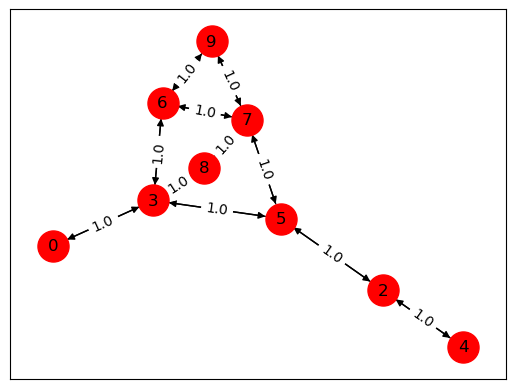

In [18]:
gb.viz.draw(gen)

In [22]:
#как ведет себя время для очень разреженых графов с увеличением числа вершин
for i in range(1000,7000,1000):
  print(f'Количество вершин: {i}, плотность {10/i**2}')
  randGraph = generate_random_graph(i, 10/i**2)
  print(test(randGraph))

Количество вершин: 1000, плотность 1e-05
[0.0, 0.0, 0.0, 0.0]
NaiveA3:
299 µs ± 13.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
NaiveA2:
249 µs ± 3.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Cohens:
461 µs ± 2.26 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Sandia:
505 µs ± 4.22 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
None
Количество вершин: 2000, плотность 2.5e-06
[0.0, 0.0, 0.0, 0.0]
NaiveA3:
363 µs ± 81.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
NaiveA2:
251 µs ± 2.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Cohens:
577 µs ± 114 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Sandia:
549 µs ± 27.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
None
Количество вершин: 3000, плотность 1.111111111111111e-06
[0.0, 0.0, 0.0, 0.0]
NaiveA3:
306 µs ± 6.32 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
NaiveA2:
263 µs ± 13.6 µs per loop (mean ± std. dev. of

1. Наивный алгоритм почти всегда быстрее алгоритмов Cohen и Sandia (так как алгоритмы Cohen и Sandia рассчитаны, в первую очередь, на более плотные графы с большим количеством вершин).
2. Наиболее эффективным по времени оказался наивный алгоритм с маской, оптимизирующий наивный алгоритм путем замены дорогой по времени операции умножения матриц на поэлементное умножение на маску.
3. Однако, результаты теста нельзя назвать значимыми для практического применения, поскольку очень редко на практике приходится работать с относительно малыми и настолько разреженными графами.

In [24]:
#как ведет себя время для графов с повышением плотности
for i in [0.005, 0.010, 0.015, 0.020, 0.025, 0.030, 0.035, 0.040, 0.045, 0.050, 0.1, 0.2, 0.3, 0.4, 0.5]:
  print(f'----------------------------------------------')
  print(f'Количество вершин: 500, плотность: {i}')
  randGraph = generate_random_graph(500, i)
  print(test(randGraph))

----------------------------------------------
Количество вершин: 500, плотность: 0.005
[3.0, 3.0, 3.0, 3.0]
NaiveA3:
1 ms ± 30.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
NaiveA2:
265 µs ± 2.71 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Cohens:
455 µs ± 32.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Sandia:
350 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
None
----------------------------------------------
Количество вершин: 500, плотность: 0.01
[21.0, 21.0, 21.0, 21.0]
NaiveA3:
2.67 ms ± 65.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
NaiveA2:
290 µs ± 5.19 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Cohens:
450 µs ± 2.26 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Sandia:
383 µs ± 6.22 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
None
----------------------------------------------
Количество вершин: 500, плотность: 0.015
[71.0, 71.0, 71.0, 71.0]
NaiveA3

1. С увеличением плотности графа с большим числом вершин наивный алгоритм стал значительно проигрывать более оптимальным подходам.
2. Наивный алгоритм с маской по-прежнему немного более эффективен за счет отказа от дорогостоящего перемножения матриц.
3. Наиболее эффективным алгоритмом по результатам теста оказался Sandia, поскольку использует только нижний треугольник исходной матрицы смежности графа. Также алгоритм наиболее эффективен и по занимаемой памяти, т.к. хранит только нижнетреугольную матрицу (в отличие от Cohen, в котором хранятся 2: верхнетреугольная и нижнетреугольная).
4. Можно сказать о том, что результаты этого теста практически применимы. Алгоритмы Sandia и Cohen's предпочтительно использовать при решении практических задач.